In [31]:
import pandas as pd
from sklearn.calibration import LabelEncoder
import numpy as np
# 1. Load the data
df = pd.read_csv('./megablunders.csv')

In [32]:
# look at class imbalances

import matplotlib.pyplot as plt

# get the count for each label
print(df["error"].value_counts())

df = df[df["error"] != "AGREEERROR"]

print(df["error"].value_counts())

error
PR            14
PAR           14
ROS           14
MM            14
DM            13
AGREE         13
CASE          13
FRAG          12
NONE          11
AGREEERROR     1
Name: count, dtype: int64
error
PR       14
PAR      14
ROS      14
MM       14
DM       13
AGREE    13
CASE     13
FRAG     12
NONE     11
Name: count, dtype: int64


In [33]:
# use lable encoder to encode the error
label_encoder = LabelEncoder()
df['error'] = label_encoder.fit_transform(df['error'])

In [34]:
#  vectorize the text 
from sentence_transformers import SentenceTransformer

st = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [35]:
embeddings = st.encode(df["original_sentence"])

KeyError: np.int64(93)

In [ ]:
df["error"].nunique()

10

In [ ]:
df.head()

,original_sentence,error
0,By dropping a game to the pathetic Tampa Bay D...,3
1,"Although, if history is any indication, the te...",4
2,"The Sox almost never go down uneventfully, whi...",8
3,Because of the accumulated bad karma that hang...,0
4,The team not only has squandered huge leads bu...,7


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['error'], test_size=0.1, random_state=42, stratify=df["error"])

NameError: name 'embeddings' is not defined

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras import regularizers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(768,),
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

/Users/felixstuart/Documents/School/Clubs/Programming Club/Potential Projects/ML Megablunders/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(X_train,y_train, batch_size=16, epochs=50, validation_data=(X_test,y_test), callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1090 - loss: 2.3317 - val_accuracy: 0.0833 - val_loss: 2.3430
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2084 - loss: 2.3265 - val_accuracy: 0.0833 - val_loss: 2.3438
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2261 - loss: 2.3071 - val_accuracy: 0.0833 - val_loss: 2.3451
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2907 - loss: 2.2875 - val_accuracy: 0.0833 - val_loss: 2.3459
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3095 - loss: 2.2806 - val_accuracy: 0.0833 - val_loss: 2.3491
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3952 - loss: 2.2646 - val_accuracy: 0.0833 - val_loss: 2.3528


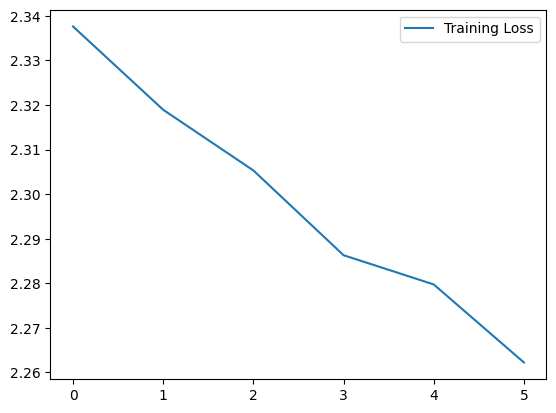

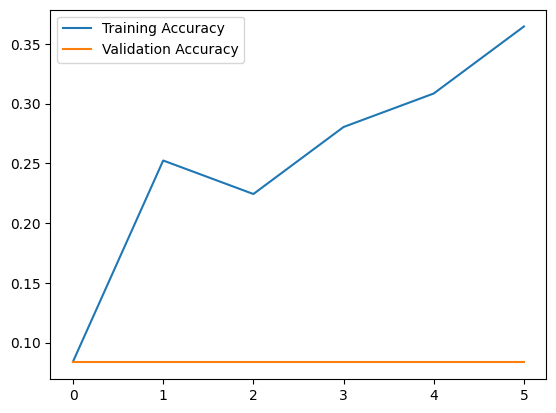

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0833 - loss: 2.3430
Test Loss: 2.3429548740386963
Test Accuracy: 0.0833333358168602


In [ ]:
# try xgboost


import xgboost as xgb
from sklearn.metrics import accuracy_score

# Fit the XGBoost model
xboost = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, random_state=42)
xboost.fit(X_train, y_train)

# Make predictions
y_pred = xboost.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy*100:.2f}%")


XGBoost Accuracy: 0.00%
